In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41131")
client

<Client: 'tcp://127.0.0.1:41131' processes=7 threads=28, memory=177.10 GiB>

In [2]:
from cil.io import NEXUSDataReader, NEXUSDataWriter
from cil.processors import RingRemover
import numpy as np
import time
import dask

In [3]:
path = "/home/xqg84736/Paper-2021-RSTA-CIL-Part-II/CaseStudy_HyperspectralTomography/HyperspectralData/"
name = "full_raw_data_flat_field_318_398_channels.nxs"
reader = NEXUSDataReader(file_name = path + name)
data = reader.load_data()

# Setup and run RingRemover Processor
wname = "db25"
decNum = 4
sigma = 1.5

In [4]:
t1 = time.time()
data_after_ring_remover = RingRemover(decNum=4, wname="db25", sigma=1.5, info=True)(data)
t2 = time.time()
print(t2-t1)

Finish channel 0
Finish channel 1
Finish channel 2
Finish channel 3
Finish channel 4
Finish channel 5
Finish channel 6
Finish channel 7
Finish channel 8
Finish channel 9
Finish channel 10
Finish channel 11
Finish channel 12
Finish channel 13
Finish channel 14
Finish channel 15
Finish channel 16
Finish channel 17
Finish channel 18
Finish channel 19
Finish channel 20
Finish channel 21
Finish channel 22
Finish channel 23
Finish channel 24
Finish channel 25
Finish channel 26
Finish channel 27
Finish channel 28
Finish channel 29
Finish channel 30
Finish channel 31
Finish channel 32
Finish channel 33
Finish channel 34
Finish channel 35
Finish channel 36
Finish channel 37
Finish channel 38
Finish channel 39
Finish channel 40
Finish channel 41
Finish channel 42
Finish channel 43
Finish channel 44
Finish channel 45
Finish channel 46
Finish channel 47
Finish channel 48
Finish channel 49
Finish channel 50
Finish channel 51
Finish channel 52
Finish channel 53
Finish channel 54
Finish channel 55
Fi

### Distribute with Dask

In [5]:
from scipy.fftpack import fftshift, ifftshift, fft, ifft
import numpy as np
import pywt

def xRemoveStripesVertical(ima, decNum, wname, sigma):
        
        ''' Code from https://doi.org/10.1364/OE.17.008567 
            translated in Python
                            
        Returns
        -------
        Corrected 2D sinogram data (Numpy Array)
        
        '''              
                            
        # allocate cH, cV, cD
        Ch = [None]*decNum
        Cv = [None]*decNum
        Cd = [None]*decNum
            
        # wavelets decomposition
        for i in range(decNum):
            ima, (Ch[i], Cv[i], Cd[i]) = pywt.dwt2(ima,wname) 
    
        # FFT transform of horizontal frequency bands
        for i in range(decNum):
            
            # use to axis=0, which correspond to the angles direction
            fCv = fftshift(fft(Cv[i], axis=0))
            my, mx = fCv.shape
            
            # damping of vertical stripe information
            damp = 1 - np.exp(-np.array([range(-int(np.floor(my/2)),-int(np.floor(my/2))+my)])**2/(2*sigma**2))
            fCv *= damp.T
             
            # inverse FFT          
            Cv[i] = np.real(ifft(ifftshift(fCv), axis=0))
                                                                    
        # wavelet reconstruction
        nima = ima
        for i in range(decNum-1,-1,-1):
            nima = nima[0:Ch[i].shape[0],0:Ch[i].shape[1]]
            nima = pywt.idwt2((nima,(Ch[i],Cv[i],Cd[i])),wname)
            
        return nima

In [6]:
results = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        tmp = dask.delayed(xRemoveStripesVertical)(data.array[i,j], decNum, wname, sigma)
        results.append(tmp)

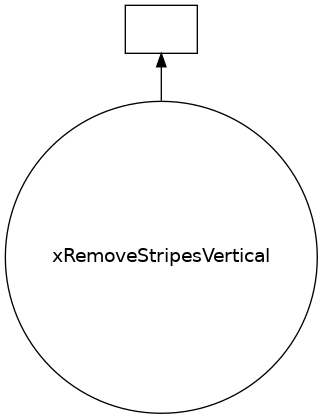

In [7]:
results[0].visualize()

In [8]:
results[0].dask

HighLevelGraph with 1 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7fa1cdab3f70>
 0. xRemoveStripesVertical-686e067e-bb08-4e24-9a48-e246fd15365c

In [9]:
t1 = time.time()
results_list = dask.compute(*results)
t2 = time.time()
print(t2-t1)

22.928839683532715


# Compare dask vs no parallel

In [10]:
k = 0
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        np.testing.assert_allclose(results_list[k],data_after_ring_remover.array[i,j])
        k+=1

In [11]:
tmp_after_ring = np.reshape(np.array(results_list),data.shape)
data_after_ring = data.geometry.allocate()
data_after_ring.fill(tmp_after_ring)
print(data_after_ring.shape)
print(data_after_ring.dimension_labels)

(80, 80, 120, 400)
('channel', 'vertical', 'angle', 'horizontal')
